In [3]:
import time
nb_start_time = time.time()
print(time.ctime())

import os,sys
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

Thu Mar 17 13:00:54 2022


In [38]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCABULARY_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [5]:
# load pre-trained glove model
word2vec = {} #empty dictionary
with open(f"../../Natural Language Processing with Deep Learning in Python/2. Beginner's Corner Working with Word Vectors/glove.6B/glove.6B.{EMBEDDING_DIM}d.txt") as f:
    for line in f:
        values = line.split()
        word = values[0].strip()
        emb = np.asarray(values[1:], dtype="float32")
        word2vec[word] = emb
        
    print(f"Found {len(word2vec)} word vectors")

Found 400000 word vectors


In [8]:
print("Loading in comments")

train = pd.read_csv("jigsaw-toxic-comment-classification-challenge/train.csv")
print(train.head())

Loading in comments
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [9]:
sentences = train['comment_text'].fillna("DUMMY_VALUE").values

In [12]:
len(sentences), type(sentences)

(159571, numpy.ndarray)

In [13]:
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [18]:
targets = train[possible_labels].values  #.values make it an array, without .values it will return a DataFRame or Series

In [20]:
print("max sequence length: ", max(len(s) for s in sentences))
print("min sequence length: ", min(len(s) for s in sentences))

max sequence length:  5000
min sequence length:  6


In [23]:
s = sorted(len(s) for s in sentences)
print("median seq length: ", s[len(s)//2])

median seq length:  205


In [28]:
# convert the strings (sentences) into intergers
tokenizer = Tokenizer(num_words = MAX_VOCABULARY_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences[0])

[688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]


In [29]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print(f"Found {len(word2idx)} unique tokens")

Found 210337 unique tokens


In [30]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print("shape of data tensor: ", data.shape)

shape of data tensor:  (159571, 100)


In [33]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCABULARY_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCABULARY_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all zeros.
          embedding_matrix[i] = embedding_vector


Filling pre-trained embeddings...


In [34]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [35]:
print('Building model...')

Building model...


In [36]:
# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

Metal device set to: Apple M1


2022-03-17 19:14:25.200693: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-17 19:14:25.201379: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [39]:
model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10


2022-03-17 19:15:11.516305: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-17 19:15:11.518897: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-17 19:15:18.591913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


998/998 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9365

2022-03-17 19:15:40.085139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


998/998 [==============================] - 31s 21ms/step - loss: 0.1024 - accuracy: 0.9366 - val_loss: 0.0720 - val_accuracy: 0.9940
Epoch 2/10
998/998 [==============================] - 21s 21ms/step - loss: 0.0689 - accuracy: 0.9935 - val_loss: 0.0701 - val_accuracy: 0.9927
Epoch 3/10
998/998 [==============================] - 20s 20ms/step - loss: 0.0624 - accuracy: 0.9899 - val_loss: 0.0693 - val_accuracy: 0.9941
Epoch 4/10
998/998 [==============================] - 20s 20ms/step - loss: 0.0593 - accuracy: 0.9938 - val_loss: 0.0666 - val_accuracy: 0.9881
Epoch 5/10
998/998 [==============================] - 20s 20ms/step - loss: 0.0559 - accuracy: 0.9936 - val_loss: 0.0764 - val_accuracy: 0.9914
Epoch 6/10
998/998 [==============================] - 21s 21ms/step - loss: 0.0547 - accuracy: 0.9933 - val_loss: 0.0741 - val_accuracy: 0.9938
Epoch 7/10
998/998 [==============================] - 21s 21ms/step - loss: 0.0529 - accuracy: 0.9937 - val_loss: 0.0753 - val_accuracy: 0.9927
Epo

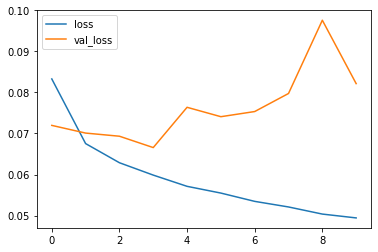

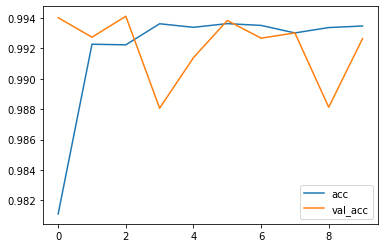

2022-03-17 19:19:29.338441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.9785127047606136


In [41]:
import matplotlib.pyplot as plt
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))